# Draft 1 - Dissertation

Sentiment analysis to understand the effect of meme community on the stock market. This paper studies how r/wallstreetbets have an impact on the stock market and how some companies are discussed more due to the relevance/popularity of the company in the general space.

# Importing Libraries

TODO: ML libraries to be added

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import yfinance as yf
import openai
from os import getenv
from dotenv import load_dotenv
import openai
import time
from datetime import datetime, timedelta

# Read the symbols into a variable 

and search any specific symbol, and/or add "$" to a paticular symbol

In [2]:
symbols = pd.read_csv('symbols.csv')
symbols.head(3)

,Symbol,Dollar_Symbol,Name
0,$A,$A,Agilent Technologies Inc. Common Stock
1,AA,$AA,Alcoa Corporation Common Stock
2,AAC,$AAC,Ares Acquisition Corporation Class A Ordinary ...


In [4]:
#search for a specific symbol
sym = '$NOW'
print(symbols.loc[symbols['Symbol'] == sym])

     Symbol Dollar_Symbol                          Name
2328   $NOW          $NOW  ServiceNow Inc. Common Stock


In [ ]:
#add a "$" to a specific Symbol column in the symbols df from the change variable matching the Symbols column
change = 'NEXT'
symbols.loc[symbols['Symbol'] == change, 'Symbol'] = '$' + change
print(symbols.loc[symbols['Symbol'] == '$'+change])
#save the symbols df in the csv file
symbols.to_csv('symbols.csv', index=False)

# Cleaning the data - Remove duplicates


In [4]:
def remove_duplicates(input_file, output_file):
    try:
        with open(input_file, 'r') as f:
            sentences = f.readlines()

        # Remove duplicates while preserving the order
        unique_sentences = list(dict.fromkeys(sentences))

        with open(output_file, 'w') as f:
            f.writelines(unique_sentences)

        print("Duplicates removed successfully and saved to", output_file)
    except FileNotFoundError:
        print("File not found. Please check the input file path.")
    except Exception as e:
        print("An error occurred:", e)

In [ ]:
# File inputs
input_file = 'hot.txt'
output_file = 'clean_hot.txt'

remove_duplicates(input_file, output_file)

# Read the hot file into a variable

In [3]:
#import the hot text file to a list
hot = open('clean_hot.txt').read().split('\n')
#count the number of items in the list
len(hot)

3211

# Make the lines into a dataframe with dates and text

this is done so it is easy to get the dates with the sentences

In [4]:
def make_dataframe(file_name):
    # Initialize a list to store the DataFrame rows
    rows = []

    # Open the file for reading
    with open(file_name, 'r') as file:
        current_date = None

        # Read the file line by line
        for line in file:
            # Check if the line matches the date format
            match = re.search(r'[-]+(\d{4}-\d{2}-\d{2})', line)
            if match:
                # Extract the date in the format "YYYY-MM-DD"
                current_date = match.group(1) # Only extract the date part without dashes

            else:
                # If the line is not a date, add it as a row in the DataFrame
                if current_date is not None: # Avoid adding rows without an associated date
                    rows.append({'date': current_date, 'text': line.strip()})

    # Create a DataFrame from the list of rows
    df = pd.DataFrame(rows, columns=['date', 'text'])

    # Print the DataFrame to see the results
    print(df)

    # Return the DataFrame
    return df

In [5]:
hot_df = make_dataframe('clean_hot.txt')

            date                                               text
0     2023-03-16       What Are Your Moves Tomorrow, March 16, 2023
1     2023-03-16  Most Anticipated Earnings Releases for the wee...
2     2023-03-16          Eggon says “GME go up” after earnings. ⬆️
3     2023-03-16  Goldman Sachs: 99% of borrowers have a mortgag...
4     2023-03-16                            Who would have thought?
...          ...                                                ...
3158  2023-08-04                       When the IRS comes after you
3159  2023-08-04  How do people lose their entire account on opt...
3160  2023-08-04                  Better Option Strategies, Advice?
3161  2023-08-04                                 Whats up with $TGT
3162  2023-08-04  You do NOT have to buy the shares when exercis...

[3163 rows x 2 columns]


In [8]:
#write hot_df into a csv file named hot_df with no index
hot_df.to_csv('hot_df.csv', index=False)

# Find the tickers in each sentence

In [6]:
def symbol_matches(sentence, symbol_list):
    matches = []
    for symbol in symbol_list:
        if pd.notna(symbol):  # Skip NaN values in the symbol_list
            pattern = r"\b" + re.escape(str(symbol)) + r"\b"
            if re.search(pattern, sentence):
                matches.append(symbol)
    return matches

def find_matches(hot_df, symbols):
    # List to store the results
    results = []

    # Iterate through each row in the DataFrame
    for index, row in hot_df.iterrows():
        date = row['date']
        sentence = row['text']

        # Find matches for each sentence with "Symbol" and "Dollar_Symbol" columns
        matches_symbols = symbol_matches(sentence, symbols['Symbol'].tolist())
        matches_dollar_symbols = symbol_matches(sentence, symbols['Dollar_Symbol'].tolist())
        all_matches = matches_symbols + matches_dollar_symbols

        # If all_matches is empty then input "S&P"
        if not all_matches:
            all_matches = ['S&P']

        # Concatenate the matches into a single string
        ticker_string = ', '.join(all_matches)

        # Append the results to the list
        results.append((date, sentence, ticker_string))

    # Create a new DataFrame to store the results
    tickers = pd.DataFrame(results, columns=["date", "text", "ticker"])

    # Print the result DataFrame
    print(tickers)

    # Return the result DataFrame  
    return tickers


In [7]:
hot_ticker = find_matches(hot_df,symbols)

            date                                               text ticker
0     2023-03-16       What Are Your Moves Tomorrow, March 16, 2023    S&P
1     2023-03-16  Most Anticipated Earnings Releases for the wee...    S&P
2     2023-03-16          Eggon says “GME go up” after earnings. ⬆️    GME
3     2023-03-16  Goldman Sachs: 99% of borrowers have a mortgag...    S&P
4     2023-03-16                            Who would have thought?    S&P
...          ...                                                ...    ...
3158  2023-08-04                       When the IRS comes after you    IRS
3159  2023-08-04  How do people lose their entire account on opt...    S&P
3160  2023-08-04                  Better Option Strategies, Advice?    S&P
3161  2023-08-04                                 Whats up with $TGT    TGT
3162  2023-08-04  You do NOT have to buy the shares when exercis...    S&P

[3163 rows x 3 columns]


In [8]:
# Filter the DataFrame to exclude rows with 'S&P' in the 'Ticker' column
non_sp_sentences = hot_ticker[hot_ticker['ticker'] != 'S&P']
len(non_sp_sentences)


671

In [9]:
sp_sentences = hot_ticker[hot_ticker['ticker'] == 'S&P']
len(sp_sentences)

2492

In [10]:
#write hot_ticker to a csv with no index
hot_ticker.to_csv('hot_ticker.csv', index=False)

In [11]:
#read hot_ticker csv to a variable name hot_ticker
hot_ticker = pd.read_csv('hot_ticker.csv')
len(hot_ticker)

3163

# FINBERT

In [12]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="ProsusAI/finbert")

/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def finbert_sentiments(pipe, df):
    # Create an empty list to store the rows
    rows = []
    
    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        date = row['date']
        text = row['text']
        ticker = row['ticker']

        # If text is a string, convert it to a list with one element
        if isinstance(text, str):
            sentences = [text]
        
        # Process the sentences through the pipeline
        results = pipe(sentences)
        
        # Iterate through the sentences and results to create rows
        for sentence, result in zip(sentences, results):
            rows.append((date, sentence, ticker, result['label'], result['score']))
            
    # Create a DataFrame from the rows
    finbert_sentiment = pd.DataFrame(rows, columns=['date', 'text', 'ticker', 'label', 'score'])
    
    return finbert_sentiment


In [14]:
hot_finbert = finbert_sentiments(pipe, hot_ticker)

In [16]:
len(hot_finbert)

3163

In [18]:
#write hot_sentiments into a csv with no index
hot_finbert.to_csv('sentiment_scores/hot_finbert.csv', index=False)

In [19]:
hot_finbert[hot_finbert['ticker'].str.contains(',')]

,date,text,ticker,label,score
176,2023-03-18,AI CEO ON GPT-4: THIS CAN GET “SUPER-DANGEROUS...,"CAN, ON",neutral,0.514608
358,2023-03-20,"$25.7K YOLO on AMD NVDA, my gf is out with Pow...","AMD, NVDA",neutral,0.873070
517,2023-03-22,Eggcellent DD - Cal-Maine Foods ($CALM).,"CALM, DD",neutral,0.901084
612,2023-03-23,SEC is Suing COIN(GME) Gamestop earnings. Let'...,"COIN, GME",neutral,0.774629
649,2023-03-24,$META and $SNAP watching the TikTok CEO gettin...,"META, SNAP",negative,0.761524
...,...,...,...,...,...
2998,2023-08-02,"AMZN & AAPL earnings tomorrow, we are so close...","AAPL, AMZN",positive,0.632043
3065,2023-08-03,$MRVI DD,"DD, MRVI",neutral,0.916330
3125,2023-08-04,FSR - My Ultimate Regard YOLO + DD,"DD, FSR",neutral,0.930915
3128,2023-08-04,Quality CVNA DD,"CVNA, DD",neutral,0.917648


# VADER

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [21]:
def vader_sentiments(df,analyzer=analyzer):
    # Create an empty list to store the rows
    rows = []
    
    # Iterate through the keys and values in hot_dict
    for index, row in df.iterrows():
        date = row['date']
        text = row['text']
        ticker = row['ticker']
        # If sentences is a string, convert it to a list with one element
        if isinstance(text, str):
            sentences = [text]
        
        # Process the sentences through the pipeline
        for sentence in sentences:
            result = analyzer.polarity_scores(sentence)
            rows.append((date, sentence, ticker, result['neg'], result['neu'], result['pos'], result['compound']))
            
    # Create a DataFrame from the rows
    vader_sentiment = pd.DataFrame(rows, columns=['date', 'text', 'ticker', 'neg', 'neu', 'pos', 'compound'])
    
    return vader_sentiment

In [22]:
hot_vader = vader_sentiments(hot_ticker)
hot_vader.head(10)

,date,text,ticker,neg,neu,pos,compound
0,2023-03-16,"What Are Your Moves Tomorrow, March 16, 2023",S&P,0.000,1.000,0.000,0.0000
1,2023-03-16,Most Anticipated Earnings Releases for the wee...,S&P,0.000,1.000,0.000,0.0000
2,2023-03-16,Eggon says “GME go up” after earnings. ⬆️,GME,0.000,1.000,0.000,0.0000
3,2023-03-16,Goldman Sachs: 99% of borrowers have a mortgag...,S&P,0.136,0.864,0.000,-0.2960
4,2023-03-16,Who would have thought?,S&P,0.000,1.000,0.000,0.0000
5,2023-03-16,Live look at banks,S&P,0.000,1.000,0.000,0.0000
6,2023-03-16,Warning from the treasury market,S&P,0.333,0.417,0.250,-0.1531
7,2023-03-16,"Credit Suisse shares suspended, banking crisis...",S&P,0.480,0.200,0.320,-0.5267
8,2023-03-16,let me introduce you to the infinite Frosty gl...,S&P,0.000,0.879,0.121,0.5106
9,2023-03-16,#DWAC and Trump Media Being investigated for M...,DWAC,0.000,1.000,0.000,0.0000


In [23]:
#write hot_vader to csv file with no index
hot_vader.to_csv('sentiment_scores/hot_vader.csv', index=False)

# ChatGPT

In [24]:
load_dotenv()
openai.api_key = getenv('OPENAI_API_KEY')


In [25]:
len(hot_ticker)

3163

In [26]:
tmp_df = pd.DataFrame()

In [27]:
def get_response(content):
    return openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": "Analyze the given text and classify it into: negative, or positive. Also provide a sentiment score within the range of -1 to 1. Score values must be calculated with high precision with up to three decimal places. Your response format should be: sentiment, score e.g., ('negative, -0.145')."
            },
            {
                "role": "user",
                "content": content
            }
        ],
        temperature=1,
        max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
def chatgpt_df(rows):
    chatgpt = pd.DataFrame(rows, columns=['date', 'text', 'ticker', 'label', 'score'])
    return chatgpt
def chatgpt_sentiments(df, tmp_df, max_retries=5, base_delay=1, analyzer=openai):
    rows = []
    total_tokens = 0
    calls_per_minute = 100
    call_interval = 60 / calls_per_minute
    last_call_time = 0
    last_token_reset_time = time.time() # Keep track of when the token count was last reset
    
    for index, row in df.iterrows():
        date = row['date']
        text = row['text']
        ticker = row['ticker']
        retries = 0
        loop_count = 0 # Counter for loop iterations without progress
        
        while retries < max_retries:
            current_time = time.time()
            time_since_last_call = current_time - last_call_time
            time_since_last_token_reset = current_time - last_token_reset_time

            if time_since_last_token_reset >= 60:
                total_tokens = 0 # Reset token count if it's been more than a minute
                last_token_reset_time = current_time

            if time_since_last_call < call_interval or total_tokens >= 60000:
                sleep_time = call_interval - time_since_last_call
                print(f"Rate limit reached, sleeping for {sleep_time} seconds...")
                time.sleep(sleep_time)
                loop_count += 1
                if loop_count > max_retries:  # Break out of the loop if too many iterations have occurred
                    print("Max loop count reached, unable to process the request.")
                    break
                continue 

            try:
                last_call_time = time.time() # Update the time of the last successful call
                result = get_response(text)
                tokens = result['usage']['total_tokens']
                total_tokens += tokens # Update the total token count
                content = result.choices[0].message['content']
                try:
                    label, score_str = content.split(',', 1) # Split only at the first comma
                    label = label.strip()
                    score = float(score_str.strip())
                except ValueError:
                    print(f"Error here: {content}")
                    label = "error"
                    score = 2
                
                rows.append((date, text, ticker, label, score))
                print(f"Sentiment captured: {score}, token_used: {tokens}, total for the min: {total_tokens}")
                break

            except openai.error.ServiceUnavailableError:
                tmp_df = chatgpt_df(rows) #save the answers till the error point.
                tmp_df.to_csv('tmp.csv', index=False) #write tmp_df to a csv file named tmp with no index
                print("Did not get result.")
                delay = base_delay * (2 ** retries)
                print(f"Service unavailable, retrying in {delay} seconds...")
                time.sleep(delay)
                retries += 1
            except Exception as e:  # Catch-all for other exceptions
                tmp_df = chatgpt_df(rows) #save the answers till the error point.
                tmp_df.to_csv('tmp.csv', index=False)
                print(f"Unexpected error: {e}")
                delay = base_delay * (2 ** retries)
                print(f"Retrying in {delay} seconds...")
                time.sleep(delay)
                retries += 1
            except KeyboardInterrupt:
                print("Operation was interrupted by the user.")
                tmp_df = chatgpt_df(rows) #save the answers till the error point.
                tmp_df.to_csv('tmp.csv', index=False)
                return chatgpt_df(rows)
        else: # This will execute if the while loop ends without a break statement
            print("Max retries reached, unable to process the request.")

    return chatgpt_df(rows)


In [157]:
# print all rows after row 697 in hot_ticker
hot_chatgpt = chatgpt_sentiments(hot_ticker,tmp_df)

Error here: I'm sorry, but the given text "How it feels" is too ambiguous to be classified as either negative or positive. It does not provide enough context to determine the sentiment.
Sentiment captured: 2, token_used: 115, total for the min: 115
Error here: Sorry, but I cannot analyze or classify a text without the actual content. Please provide the summary of Yellen's testimony for me to analyze.
Sentiment captured: 2, token_used: 112, total for the min: 227
Error here: Sorry, but I cannot analyze the sentiment of the given text as it does not contain any sentiment.
Sentiment captured: 2, token_used: 100, total for the min: 327
Sentiment captured: 0.25, token_used: 84, total for the min: 411
Error here: It appears that "MEIRL" is not a text or statement for classification. Please provide a valid text for analysis.
Sentiment captured: 2, token_used: 104, total for the min: 515
Error here: I'm sorry, but as an AI language model, I am unable to browse the internet or access specific w

In [171]:
hot_chatgpt.head(70)

,date,text,ticker,label,score
0,2023-03-16,"What Are Your Moves Tomorrow, March 16, 2023",S&P,neutral,0.000
1,2023-03-16,Most Anticipated Earnings Releases for the wee...,S&P,positive,0.250
2,2023-03-16,Eggon says “GME go up” after earnings. ⬆️,GME,positive,0.700
3,2023-03-16,Goldman Sachs: 99% of borrowers have a mortgag...,S&P,Positive,0.981
4,2023-03-16,Who would have thought?,S&P,neutral,0.000
...,...,...,...,...,...
65,2023-03-16,Life moves pretty fast when you're having fun,S&P,positive,0.500
66,2023-03-16,Jackson Hole 2.0 Speech Leak,S&P,negative,-0.843
67,2023-03-16,I’m a fucking degenerate regard - YOLO 100x SP...,S&P,negative,-0.944
68,2023-03-16,100% Batting Average today- +$12k,S&P,positive,1.000


In [159]:
merged_df = pd.merge(hot_chatgpt, tmp, on='text', suffixes=('_hot', '_tmp'))

# Iterate through the merged DataFrame and update the label and score in hot_chatgpt
for index, row in merged_df.iterrows():
    hot_index = hot_chatgpt[hot_chatgpt['text'] == row['text']].index.item()
    hot_chatgpt.at[hot_index, 'label'] = row['label_tmp']
    hot_chatgpt.at[hot_index, 'score'] = row['score_tmp']


In [163]:
hot_chatgpt[hot_chatgpt['text'] == 'OK analyst']

,date,text,ticker,label,score
909,2023-04-01,OK analyst,S&P,positive,0.25


In [161]:
# write hot_chatgpt to hot_chatgpt.csv with no index using pandas
hot_chatgpt.to_csv('sentiment_scores/hot_chatgpt.csv', index=False)

In [28]:
#read the tmp.csv file into a variavle name tmp1
hot_chatgpt = pd.read_csv('sentiment_scores/hot_chatgpt.csv')
hot_chatgpt.head(10)


,date,text,ticker,label,score
0,2023-03-16,"What Are Your Moves Tomorrow, March 16, 2023",S&P,neutral,0.000
1,2023-03-16,Most Anticipated Earnings Releases for the wee...,S&P,positive,0.250
2,2023-03-16,Eggon says “GME go up” after earnings. ⬆️,GME,positive,0.700
3,2023-03-16,Goldman Sachs: 99% of borrowers have a mortgag...,S&P,Positive,0.981
4,2023-03-16,Who would have thought?,S&P,neutral,0.000
5,2023-03-16,Live look at banks,S&P,neutral,0.000
6,2023-03-16,Warning from the treasury market,S&P,negative,-0.253
7,2023-03-16,"Credit Suisse shares suspended, banking crisis...",S&P,negative,-0.687
8,2023-03-16,let me introduce you to the infinite Frosty gl...,S&P,negative,-0.333
9,2023-03-16,#DWAC and Trump Media Being investigated for M...,DWAC,negative,-0.789


In [29]:
#print all the labels in hot_chatgpt which are 'error'
hot_chatgpt[hot_chatgpt['label'] == 'error']

,date,text,ticker,label,score
71,2023-03-16,How it feels,S&P,error,2.0
74,2023-03-16,Summary of Yellen’s testimony yesterday,S&P,error,2.0
718,2023-03-25,Who would win?,S&P,error,2.0
953,2023-04-01,MEIRL,S&P,error,2.0
1036,2023-04-03,Trust Pilot reviews for COIN.,COIN,error,2.0
1402,2023-06-23,Does this count?,S&P,error,2.0
1665,2023-07-04,Thoughts on $DPST,S&P,error,2.0
1999,2023-07-13,RKLB,RKLB,error,2.0
2084,2023-07-15,Give me investment advice based on this unknow...,S&P,error,2.0
2174,2023-07-16,What's the sentiment towards TSLA Earning?,TSLA,error,2.0


# ChatGPT calculations

In [45]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

# Make sure to download the NLTK tokenizer models
nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/cjs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
def count_tokens(df):
    total = 0
    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        text = row['text']
        
        # Tokenize the text using NLTK
        tokens = word_tokenize(text)
        
        # Count the number of tokens
        num_tokens = len(tokens)
        
        total += num_tokens
        # Print the number of tokens
        print(f"Number of tokens in row {index}: {num_tokens}")
    print(f" Total number of tokens {total}")
    return total

In [48]:
tokens = count_tokens(hot_df)

Number of tokens in row 0: 10
Number of tokens in row 1: 12
Number of tokens in row 2: 11
Number of tokens in row 3: 17
Number of tokens in row 4: 5
Number of tokens in row 5: 4
Number of tokens in row 6: 5
Number of tokens in row 7: 8
Number of tokens in row 8: 28
Number of tokens in row 9: 12
Number of tokens in row 10: 14
Number of tokens in row 11: 11
Number of tokens in row 12: 13
Number of tokens in row 13: 8
Number of tokens in row 14: 3
Number of tokens in row 15: 18
Number of tokens in row 16: 8
Number of tokens in row 17: 3
Number of tokens in row 18: 6
Number of tokens in row 19: 5
Number of tokens in row 20: 3
Number of tokens in row 21: 17
Number of tokens in row 22: 26
Number of tokens in row 23: 21
Number of tokens in row 24: 4
Number of tokens in row 25: 17
Number of tokens in row 26: 9
Number of tokens in row 27: 9
Number of tokens in row 28: 7
Number of tokens in row 29: 12
Number of tokens in row 30: 16
Number of tokens in row 31: 1
Number of tokens in row 32: 16
Num

In [53]:
tokensgpt = tokens /1000
print(f" Charged tokens {tokensgpt}")
price_gpt3 = 0.0015
print(f" Price per token for GPT_3 4K {price_gpt3}")
print(f" Total cost ${tokensgpt * price_gpt3}")
iterations = 50
print(f" Iterations cost ${(tokensgpt * price_gpt3)*iterations}")

 Charged tokens 33.063
 Price per token for GPT_3 4K 0.0015
 Total cost $0.04959450000000001
 Iterations cost $2.479725


# LLaMA 2

# Price download and calculations


In [30]:
ticker_rank = hot_ticker['ticker'].value_counts().sort_values(ascending=False)
ticker_rank = ticker_rank.reset_index()
ticker_rank.columns = ['Ticker', 'Count']

In [57]:
ticker_rank_2 = ticker_rank[ticker_rank['Count'] > 3]
ticker_list = ticker_rank_2['Ticker'].tolist()
len(ticker_list)

34

In [59]:
def download_stock_data(ticker):
    start_date = pd.to_datetime('2022-08-02')
    end_date = pd.to_datetime('2023-08-08')
    #download the stock
    data = yf.download(ticker, start=start_date, end=end_date)
    return data


In [61]:
for ticker in ticker_list:
    print(ticker)
    # Call the download_stock_data function to get adjusted closing prices
    stock_data = download_stock_data(ticker)
    #write the stock data to a csv file in the price_data folder
    stock_data.to_csv('price_data/'+ticker+'.csv')

S&P
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['S&P']: Exception('%ticker%: No timezone found, symbol may be delisted')



TSLA
[*********************100%***********************]  1 of 1 completed
NVDA
[*********************100%***********************]  1 of 1 completed
CVNA
[*********************100%***********************]  1 of 1 completed
UBS
[*********************100%***********************]  1 of 1 completed
PYPL
[*********************100%***********************]  1 of 1 completed
RIVN
[*********************100%***********************]  1 of 1 completed
AMC
[*********************100%***********************]  1 of 1 completed
DISH
[*********************100%***********************]  1 of 1 completed
AAPL
[*********************100%***********************]  1 of 1 completed
AMD
[*********************100%***********************]  1 of 1 completed
RTX
[*********************100%***********************]  1 of 1 completed
HOOD
[*********************100%***********************]  1 of 1 completed
ES
[*********************100%***********************]  1 of 1 completed
MSFT
[*********************100%************

In [62]:
#test S&P 500 since the symbol in yf is unique
sp = download_stock_data("^GSPC")
sp.head()
#write it to a csv file
sp.to_csv('price_data/S&P.csv')

[*********************100%***********************]  1 of 1 completed


In [63]:
def read_price_data(ticker_list):
    data_dict = {}
    for ticker in ticker_list:
        file_path = os.path.join('price_data', f'{ticker}.csv')
        if os.path.exists(file_path):
            data_dict[ticker] = pd.read_csv(file_path)
        else:
            print(f"File for {ticker} does not exist!")
    
    return data_dict

In [64]:
price_data = read_price_data(ticker_list)

In [65]:
price_data['S&P'].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-08-02,4104.209961,4140.470215,4079.810059,4091.189941,4091.189941,4727710000
1,2022-08-03,4107.959961,4167.660156,4107.959961,4155.169922,4155.169922,4351760000
2,2022-08-04,4154.850098,4161.290039,4135.419922,4151.939941,4151.939941,4283320000
3,2022-08-05,4115.870117,4151.580078,4107.310059,4145.189941,4145.189941,4085940000
4,2022-08-08,4155.930176,4186.620117,4128.970215,4140.060059,4140.060059,4221090000


In [66]:
def calculate_returns(price_data):
    for ticker, df in price_data.items():
        close_prices = df['Close'].tolist()
        returns = [0]  # Initialize returns with 0 for the first item
        for i in range(1, len(close_prices)):
            ret = (close_prices[i] - close_prices[i-1]) / close_prices[i-1]
            returns.append(ret)
        df['Returns'] = returns
        price_data[ticker] = df  # Update the dictionary with the modified DataFrame
    return price_data


In [67]:
price_data_ret = calculate_returns(price_data)
price_data_ret['S&P'].head()


,Date,Open,High,Low,Close,Adj Close,Volume,Returns
0,2022-08-02,4104.209961,4140.470215,4079.810059,4091.189941,4091.189941,4727710000,0.000000
1,2022-08-03,4107.959961,4167.660156,4107.959961,4155.169922,4155.169922,4351760000,0.015638
2,2022-08-04,4154.850098,4161.290039,4135.419922,4151.939941,4151.939941,4283320000,-0.000777
3,2022-08-05,4115.870117,4151.580078,4107.310059,4145.189941,4145.189941,4085940000,-0.001626
4,2022-08-08,4155.930176,4186.620117,4128.970215,4140.060059,4140.060059,4221090000,-0.001238


## Add returns to the sentiment scores.

In [101]:
# read the sentiment files
hot_finbert = pd.read_csv('sentiment_scores/hot_finbert.csv')
hot_vader = pd.read_csv('sentiment_scores/hot_vader.csv')
hot_chatgpt = pd.read_csv('sentiment_scores/hot_chatgpt.csv')

In [102]:
def merge_returns(sentiment_df, price_data_ret=price_data_ret):
    returns = []  # List to store the returns that will be matched

    # Iterate through the rows in sentiment_df
    for index, row in sentiment_df.iterrows():
        ticker = row['ticker']
        date = row['date']

        # Check if the ticker exists in price_data_ret
        if ticker in price_data_ret:
            ticker_df = price_data_ret[ticker]
        else:
            # If ticker not found, use the 'S&P' DataFrame
            ticker_df = price_data_ret['S&P']

        # Check if the date exists in the DataFrame for the ticker
        matching_date = ticker_df[ticker_df['Date'] == date]

        # If a matching date is found, get the corresponding return
        if not matching_date.empty:
            ret = matching_date['Returns'].iloc[0]
            returns.append(ret)
        else:
            returns.append(None)  # If date not found, append None

    # Add the returns list as a new column in sentiment_df
    sentiment_df['ret'] = returns

    return sentiment_df


In [103]:
hot_finbert_ret = merge_returns(hot_finbert)
hot_finbert_ret.head()

,date,text,ticker,label,score,ret
0,2023-03-16,"What Are Your Moves Tomorrow, March 16, 2023",S&P,neutral,0.901751,0.017562
1,2023-03-16,Most Anticipated Earnings Releases for the wee...,S&P,neutral,0.846477,0.017562
2,2023-03-16,Eggon says “GME go up” after earnings. ⬆️,GME,neutral,0.465376,0.050784
3,2023-03-16,Goldman Sachs: 99% of borrowers have a mortgag...,S&P,negative,0.776503,0.017562
4,2023-03-16,Who would have thought?,S&P,neutral,0.783594,0.017562


In [104]:
hot_vader_ret = merge_returns(hot_vader)
hot_vader_ret.head()

,date,text,ticker,neg,neu,pos,compound,ret
0,2023-03-16,"What Are Your Moves Tomorrow, March 16, 2023",S&P,0.000,1.000,0.0,0.000,0.017562
1,2023-03-16,Most Anticipated Earnings Releases for the wee...,S&P,0.000,1.000,0.0,0.000,0.017562
2,2023-03-16,Eggon says “GME go up” after earnings. ⬆️,GME,0.000,1.000,0.0,0.000,0.050784
3,2023-03-16,Goldman Sachs: 99% of borrowers have a mortgag...,S&P,0.136,0.864,0.0,-0.296,0.017562
4,2023-03-16,Who would have thought?,S&P,0.000,1.000,0.0,0.000,0.017562


In [105]:
hot_chatgpt_ret = merge_returns(hot_chatgpt)
hot_chatgpt_ret.head()

,date,text,ticker,label,score,ret
0,2023-03-16,"What Are Your Moves Tomorrow, March 16, 2023",S&P,neutral,0.000,0.017562
1,2023-03-16,Most Anticipated Earnings Releases for the wee...,S&P,positive,0.250,0.017562
2,2023-03-16,Eggon says “GME go up” after earnings. ⬆️,GME,positive,0.700,0.050784
3,2023-03-16,Goldman Sachs: 99% of borrowers have a mortgag...,S&P,Positive,0.981,0.017562
4,2023-03-16,Who would have thought?,S&P,neutral,0.000,0.017562


In [106]:
hot_finbert_ret.to_csv('sentiment_score_ret/hot_finbert_ret.csv', index= False)
hot_vader_ret.to_csv('sentiment_score_ret/hot_vader_ret.csv', index= False)
hot_chatgpt_ret.to_csv('sentiment_score_ret/hot_chatgpt_ret.csv', index= False)

In [107]:
hot_finbert_ret = pd.read_csv('sentiment_score_ret/hot_finbert_ret.csv')
hot_vader_ret = pd.read_csv('sentiment_score_ret/hot_vader_ret.csv')
hot_chatgpt_ret = pd.read_csv('sentiment_score_ret/hot_chatgpt_ret.csv')

# Price Prediction


In [134]:
from keras.layers import Input, Embedding, LSTM, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [120]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def model_LSTM(df, max_words=10000):
    df['text'] = df['text'].astype(str)
    
    # Label encoding for 'label' column
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
    ticker_encoder = LabelEncoder()
    df['ticker'] = ticker_encoder.fit_transform(df['ticker'])

    df['score'] = df['score'].astype(float)
    # Separate features and target variable
    X = df[['text', 'label', 'ticker', 'score']]
    y = (df['ret'] > 0).astype(int)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tokenize and pad the 'text' column for training and testing sets
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train['text'])
    train_text_sequences = tokenizer.texts_to_sequences(X_train['text'])
    test_text_sequences = tokenizer.texts_to_sequences(X_test['text'])
    max_sequence_length = max(len(s) for s in train_text_sequences + test_text_sequences)
    train_text_padded = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
    test_text_padded = pad_sequences(test_text_sequences, maxlen=max_sequence_length)

    # Text Input (LSTM)
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    text_embedding = Embedding(input_dim=max_words, output_dim=128)(text_input)
    text_lstm = LSTM(128, return_sequences=True)(text_embedding)
    text_lstm2 = LSTM(64)(text_lstm) # Additional LSTM layer
    text_dense = Dense(32, activation='relu')(text_lstm2)

    # Ticker Input (numeric)
    ticker_input = Input(shape=(1,), name='ticker_input')
    ticker_dense = Dense(16, activation='relu')(ticker_input)

    # Label Input (numeric)
    label_input = Input(shape=(1,), name='label_input')
    label_dense = Dense(16, activation='relu')(label_input)

    # Score Input (numeric)
    score_input = Input(shape=(1,), name='score_input')
    score_dense1 = Dense(16, activation='relu')(score_input)
    score_dense2 = Dense(8, activation='relu')(score_dense1) # Additional dense layer

    # Concatenate all inputs
    concatenated = concatenate([text_dense, ticker_dense, label_dense, score_dense2])
    dense_1 = Dense(64, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(dense_1)

    # Build and compile the model
    model = Model(inputs=[text_input, ticker_input, label_input, score_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model summary
    model.summary()

    # Train the model
    history = model.fit(
        {'text_input': train_text_padded, 'ticker_input': X_train['ticker'].values, 'label_input': X_train['label'].values, 'score_input': X_train['score'].values},
        y_train,
        epochs=5,
        batch_size=32,
        validation_split=0.2
    )

    # Plot the loss
    plot_loss(history)

    # Evaluate the model
    loss, accuracy = model.evaluate(
        {'text_input': test_text_padded, 'ticker_input': X_test['ticker'].values, 'label_input': X_test['label'].values, 'score_input': X_test['score'].values},
        y_test
    )
    print("Test Accuracy: {:.2f}%".format(accuracy * 100))



Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 lstm_19 (LSTM)              (None, 32, 128)              131584    ['embedding_14[0][0]']        
                                                                                                  
 score_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                           

2023-08-15 19:25:30.473829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:25:31.716096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:25:33.298333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:25:36.842211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:25:38.599879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 1.9912 - accuracy: 0.5158

2023-08-15 19:25:58.659550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:25:59.264587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:26:00.020051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 35s 361ms/step - loss: 1.9912 - accuracy: 0.5158 - val_loss: 0.8539 - val_accuracy: 0.6107
Epoch 2/5
64/64 [==============================] - 8s 124ms/step - loss: 0.7602 - accuracy: 0.5188 - val_loss: 0.6851 - val_accuracy: 0.6107
Epoch 3/5
64/64 [==============================] - 6s 88ms/step - loss: 0.6607 - accuracy: 0.6156 - val_loss: 0.8311 - val_accuracy: 0.5277
Epoch 4/5
64/64 [==============================] - 4s 64ms/step - loss: 0.3927 - accuracy: 0.8315 - val_loss: 1.1639 - val_accuracy: 0.4447
Epoch 5/5
64/64 [==============================] - 4s 68ms/step - loss: 0.2309 - accuracy: 0.9106 - val_loss: 1.3479 - val_accuracy: 0.4980


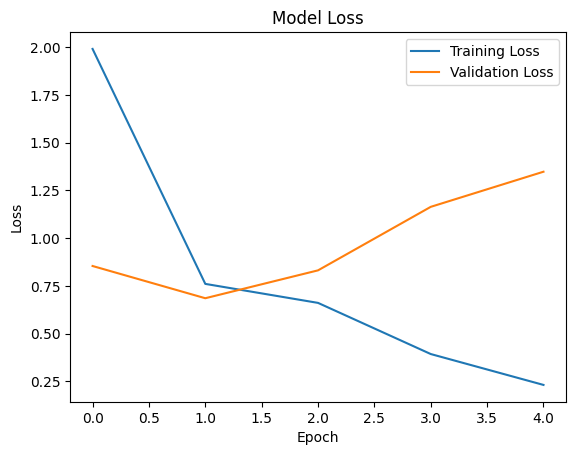

20/20 [==============================] - 2s 93ms/step - loss: 1.3396 - accuracy: 0.5466
Test Accuracy: 54.66%


In [122]:
model_LSTM(hot_finbert_ret)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_17 (Embedding)    (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 lstm_25 (LSTM)              (None, 32, 128)              131584    ['embedding_17[0][0]']        
                                                                                                  
 score_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                           

2023-08-15 19:52:51.811843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:52:59.160817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:53:00.832790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:53:05.649320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:53:07.990898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 3.8580 - accuracy: 0.5153

2023-08-15 19:53:38.829157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:53:40.552541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:53:42.935997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 98s 598ms/step - loss: 3.8580 - accuracy: 0.5153 - val_loss: 0.7918 - val_accuracy: 0.4407
Epoch 2/5
64/64 [==============================] - 13s 201ms/step - loss: 0.7527 - accuracy: 0.5425 - val_loss: 0.9298 - val_accuracy: 0.5949
Epoch 3/5
64/64 [==============================] - 8s 117ms/step - loss: 0.7356 - accuracy: 0.5450 - val_loss: 0.6829 - val_accuracy: 0.6047
Epoch 4/5
64/64 [==============================] - 6s 93ms/step - loss: 0.7135 - accuracy: 0.5707 - val_loss: 0.8301 - val_accuracy: 0.6126
Epoch 5/5
64/64 [==============================] - 10s 152ms/step - loss: 0.6918 - accuracy: 0.6082 - val_loss: 0.7238 - val_accuracy: 0.5079


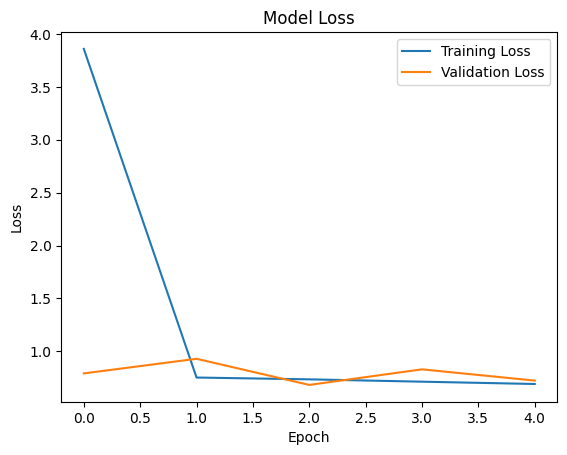

20/20 [==============================] - 2s 98ms/step - loss: 0.7280 - accuracy: 0.5450
Test Accuracy: 54.50%


In [129]:
model_LSTM(hot_chatgpt)

In [127]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate
from tensorflow.keras.models import Model

def model_LSTM_vader(df, max_words=10000):
    df['text'] = df['text'].astype(str)

    # Label encoding for 'ticker' column
    ticker_encoder = LabelEncoder()
    df['ticker'] = ticker_encoder.fit_transform(df['ticker'])

    # Separate features and target variable
    X = df[['text', 'ticker', 'neg', 'neu', 'pos', 'compound']]
    y = (df['ret'] > 0).astype(int)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tokenize and pad the 'text' column for training and testing sets
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train['text'])
    train_text_sequences = tokenizer.texts_to_sequences(X_train['text'])
    test_text_sequences = tokenizer.texts_to_sequences(X_test['text'])
    max_sequence_length = max(len(s) for s in train_text_sequences + test_text_sequences)
    train_text_padded = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
    test_text_padded = pad_sequences(test_text_sequences, maxlen=max_sequence_length)

    # Text Input (LSTM)
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    text_embedding = Embedding(input_dim=max_words, output_dim=128)(text_input)
    text_lstm = LSTM(128, return_sequences=True)(text_embedding)
    text_lstm2 = LSTM(64)(text_lstm)
    text_dense = Dense(32, activation='relu')(text_lstm2)

    # Ticker Input (numeric)
    ticker_input = Input(shape=(1,), name='ticker_input')
    ticker_dense = Dense(16, activation='relu')(ticker_input)

    # Other Numeric Inputs (neg, neu, pos, compound)
    other_inputs = Input(shape=(4,), name='other_inputs')  # 4 numeric features
    other_dense = Dense(16, activation='relu')(other_inputs)

    # Concatenate all inputs
    concatenated = concatenate([text_dense, ticker_dense, other_dense])
    dense_1 = Dense(64, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(dense_1)

    # Build and compile the model
    model = Model(inputs=[text_input, ticker_input, other_inputs], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Model summary
    model.summary()

    # Train the model
    history = model.fit(
        {'text_input': train_text_padded, 'ticker_input': X_train['ticker'].values, 'other_inputs': X_train[['neg', 'neu', 'pos', 'compound']].values},
        y_train,
        epochs=5,
        batch_size=32,
        validation_split=0.2
    )

    # Plot the loss
    plot_loss(history)

    # Evaluate the model
    loss, accuracy = model.evaluate(
        {'text_input': test_text_padded, 'ticker_input': X_test['ticker'].values, 'other_inputs': X_test[['neg', 'neu', 'pos', 'compound']].values},
        y_test
    )
    print("Test Accuracy: {:.2f}%".format(accuracy * 100))

    return model


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_16 (Embedding)    (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 lstm_23 (LSTM)              (None, 32, 128)              131584    ['embedding_16[0][0]']        
                                                                                                  
 lstm_24 (LSTM)              (None, 64)                   49408     ['lstm_23[0][0]']             
                                                                                           

2023-08-15 19:35:37.898483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:35:38.868834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:35:40.182443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:35:44.023027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:35:45.599858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 5.0536 - accuracy: 0.4911

2023-08-15 19:36:05.280363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:36:05.811536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 19:36:06.517776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 36s 363ms/step - loss: 5.0536 - accuracy: 0.4911 - val_loss: 0.6815 - val_accuracy: 0.5771
Epoch 2/5
64/64 [==============================] - 7s 109ms/step - loss: 0.7399 - accuracy: 0.5548 - val_loss: 0.6727 - val_accuracy: 0.6126
Epoch 3/5
64/64 [==============================] - 6s 94ms/step - loss: 0.7093 - accuracy: 0.5618 - val_loss: 0.6725 - val_accuracy: 0.6146
Epoch 4/5
64/64 [==============================] - 6s 86ms/step - loss: 0.6882 - accuracy: 0.5800 - val_loss: 0.6909 - val_accuracy: 0.6126
Epoch 5/5
64/64 [==============================] - 6s 86ms/step - loss: 0.5633 - accuracy: 0.7016 - val_loss: 0.9106 - val_accuracy: 0.4387


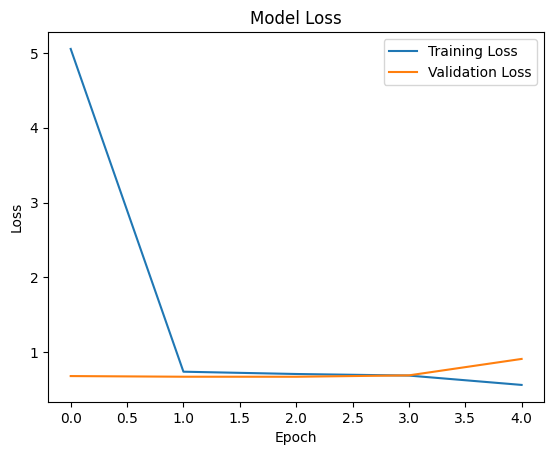

20/20 [==============================] - 2s 87ms/step - loss: 0.8795 - accuracy: 0.4581
Test Accuracy: 45.81%


In [128]:
model_LSTM_vader(hot_vader_ret)

# CNN

In [136]:
def model_CNN(df, max_words=10000):
    df['text'] = df['text'].astype(str)

    # One-hot encoding for 'label' and 'ticker' columns
    one_hot_encoder = OneHotEncoder(sparse=False)
    label_one_hot = one_hot_encoder.fit_transform(df[['label']])
    ticker_one_hot = one_hot_encoder.fit_transform(df[['ticker']])

    df['score'] = df['score'].astype(float)

    # Separate features and target variable
    X_text = df['text']
    X_ticker = ticker_one_hot
    X_label = label_one_hot
    X_score = df['score'].values.reshape(-1, 1)
    y = (df['ret'] > 0).astype(int)

    # Split the data into training and testing sets
    X_train_text, X_test_text, X_train_ticker, X_test_ticker, X_train_label, X_test_label, X_train_score, X_test_score, y_train, y_test = train_test_split(X_text, X_ticker, X_label, X_score, y, test_size=0.2, random_state=42)

    # Tokenize and pad the 'text' column for training and testing sets
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train_text)
    train_text_sequences = tokenizer.texts_to_sequences(X_train_text)
    test_text_sequences = tokenizer.texts_to_sequences(X_test_text)
    max_sequence_length = max(len(s) for s in train_text_sequences + test_text_sequences)
    train_text_padded = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
    test_text_padded = pad_sequences(test_text_sequences, maxlen=max_sequence_length)

    # Text Input (CNN)
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    text_embedding = Embedding(input_dim=max_words, output_dim=128)(text_input)
    text_conv1 = Conv1D(128, 3, activation='relu')(text_embedding)  # Reduced kernel size
    text_pool1 = MaxPooling1D(3)(text_conv1)                        # Reduced pooling size
    text_conv2 = Conv1D(128, 3, activation='relu')(text_pool1)      # Reduced kernel size
    text_pool2 = MaxPooling1D(3)(text_conv2)                        # Reduced pooling size
    text_flat = GlobalMaxPooling1D()(text_pool2)
    text_dense = Dense(32, activation='relu')(text_flat)
    # Ticker Input (numeric)
    ticker_input_shape = X_ticker.shape[1]
    ticker_input = Input(shape=(ticker_input_shape,), name='ticker_input')

    # Label Input (numeric)
    label_input_shape = X_label.shape[1]
    label_input = Input(shape=(label_input_shape,), name='label_input')

    # Score Input (numeric)
    score_input = Input(shape=(1,), name='score_input')

    # Concatenate all inputs
    concatenated = concatenate([text_dense, ticker_input, label_input, score_input])
    dense_1 = Dense(64, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(dense_1)

    # Build and compile the model
    model = Model(inputs=[text_input, ticker_input, label_input, score_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Model summary
    model.summary()

    # Train the model
    history = model.fit(
        {'text_input': train_text_padded, 'ticker_input': X_train_ticker, 'label_input': X_train_label, 'score_input': X_train_score},
        y_train,
        epochs=5,
        batch_size=32,
        validation_split=0.2
    )

    # Plot the loss
    plot_loss(history)

    # Evaluate the model
    loss, accuracy = model.evaluate(
        {'text_input': test_text_padded, 'ticker_input': X_test_ticker, 'label_input': X_test_label, 'score_input': X_test_score},
        y_test
    )
    print("Test Accuracy: {:.2f}%".format(accuracy * 100))

/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_20 (Embedding)    (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 conv1d_2 (Conv1D)           (None, 30, 128)              49280     ['embedding_20[0][0]']        
                                                                                                  
 max_pooling1d_2 (MaxPoolin  (None, 10, 128)              0         ['conv1d_2[0][0]']            
 g1D)                                                                                      

2023-08-15 20:19:28.143251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 0.6744 - accuracy: 0.6013

2023-08-15 20:19:51.268966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 29s 303ms/step - loss: 0.6744 - accuracy: 0.6013 - val_loss: 0.6713 - val_accuracy: 0.6107
Epoch 2/5
64/64 [==============================] - 6s 93ms/step - loss: 0.6674 - accuracy: 0.6052 - val_loss: 0.6712 - val_accuracy: 0.6107
Epoch 3/5
64/64 [==============================] - 4s 71ms/step - loss: 0.6316 - accuracy: 0.6329 - val_loss: 0.7083 - val_accuracy: 0.5692
Epoch 4/5
64/64 [==============================] - 4s 61ms/step - loss: 0.4492 - accuracy: 0.7762 - val_loss: 1.0226 - val_accuracy: 0.5356
Epoch 5/5
64/64 [==============================] - 4s 59ms/step - loss: 0.3730 - accuracy: 0.8088 - val_loss: 1.0885 - val_accuracy: 0.5553


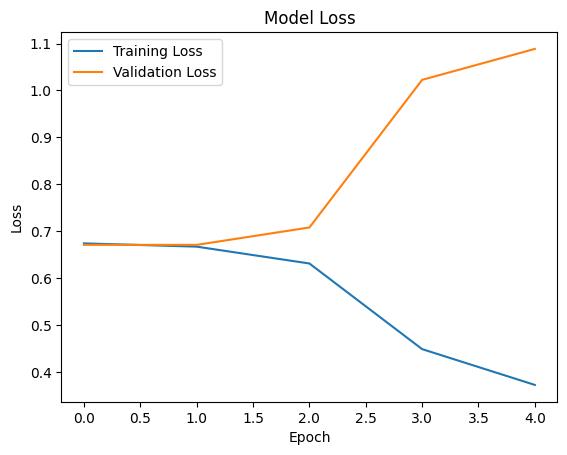

20/20 [==============================] - 2s 83ms/step - loss: 0.9495 - accuracy: 0.5656
Test Accuracy: 56.56%


In [137]:
model_CNN(hot_finbert)

/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_21 (Embedding)    (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 conv1d_4 (Conv1D)           (None, 30, 128)              49280     ['embedding_21[0][0]']        
                                                                                                  
 max_pooling1d_4 (MaxPoolin  (None, 10, 128)              0         ['conv1d_4[0][0]']            
 g1D)                                                                                      

2023-08-15 20:21:15.399313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.5983

2023-08-15 20:21:34.268036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 23s 286ms/step - loss: 0.6797 - accuracy: 0.5983 - val_loss: 0.6688 - val_accuracy: 0.6126
Epoch 2/5
64/64 [==============================] - 7s 112ms/step - loss: 0.6701 - accuracy: 0.6067 - val_loss: 0.6662 - val_accuracy: 0.6126
Epoch 3/5
64/64 [==============================] - 5s 78ms/step - loss: 0.6162 - accuracy: 0.6630 - val_loss: 0.7364 - val_accuracy: 0.5771
Epoch 4/5
64/64 [==============================] - 4s 63ms/step - loss: 0.4327 - accuracy: 0.7777 - val_loss: 0.9695 - val_accuracy: 0.5810
Epoch 5/5
64/64 [==============================] - 4s 55ms/step - loss: 0.3631 - accuracy: 0.8113 - val_loss: 1.0847 - val_accuracy: 0.5534


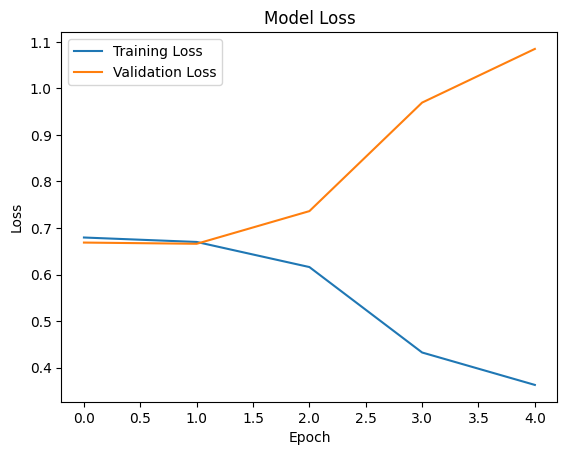

20/20 [==============================] - 2s 78ms/step - loss: 1.0334 - accuracy: 0.5261
Test Accuracy: 52.61%


In [138]:
model_CNN(hot_chatgpt)

In [140]:
def model_CNN_vader(df, max_words=10000):
    df['text'] = df['text'].astype(str)

    # One-hot encoding for 'ticker' column
    one_hot_encoder = OneHotEncoder(sparse=False)
    ticker_one_hot = one_hot_encoder.fit_transform(df[['ticker']])

    # Separate features and target variable
    X_text = df['text']
    X_ticker = ticker_one_hot
    X_neg = df['neg'].values.reshape(-1, 1)
    X_neu = df['neu'].values.reshape(-1, 1)
    X_pos = df['pos'].values.reshape(-1, 1)
    X_compound = df['compound'].values.reshape(-1, 1)
    y = (df['ret'] > 0).astype(int)

    # Split the data into training and testing sets
    splits = train_test_split(X_text, X_ticker, X_neg, X_neu, X_pos, X_compound, y, test_size=0.2, random_state=42)
    X_train_text, X_test_text, X_train_ticker, X_test_ticker, X_train_neg, X_test_neg, X_train_neu, X_test_neu, X_train_pos, X_test_pos, X_train_compound, X_test_compound, y_train, y_test = splits

    # Tokenize and pad the 'text' column
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train_text)
    train_text_sequences = tokenizer.texts_to_sequences(X_train_text)
    test_text_sequences = tokenizer.texts_to_sequences(X_test_text)
    max_sequence_length = max(len(s) for s in train_text_sequences + test_text_sequences)
    train_text_padded = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
    test_text_padded = pad_sequences(test_text_sequences, maxlen=max_sequence_length)

    # Text Input (CNN)
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    text_embedding = Embedding(input_dim=max_words, output_dim=128)(text_input)
    text_conv1 = Conv1D(128, 3, activation='relu')(text_embedding)
    text_pool1 = MaxPooling1D(3)(text_conv1)
    text_conv2 = Conv1D(128, 3, activation='relu')(text_pool1)
    text_pool2 = MaxPooling1D(3)(text_conv2)
    text_flat = GlobalMaxPooling1D()(text_pool2)
    text_dense = Dense(32, activation='relu')(text_flat)

    # Additional Inputs (numeric)
    ticker_input = Input(shape=(X_ticker.shape[1],), name='ticker_input')
    neg_input = Input(shape=(1,), name='neg_input')
    neu_input = Input(shape=(1,), name='neu_input')
    pos_input = Input(shape=(1,), name='pos_input')
    compound_input = Input(shape=(1,), name='compound_input')

    # Concatenate all inputs
    concatenated = concatenate([text_dense, ticker_input, neg_input, neu_input, pos_input, compound_input])
    dense_1 = Dense(64, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(dense_1)

    # Build and compile the model
    model = Model(inputs=[text_input, ticker_input, neg_input, neu_input, pos_input, compound_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        {'text_input': train_text_padded, 'ticker_input': X_train_ticker, 'neg_input': X_train_neg, 'neu_input': X_train_neu, 'pos_input': X_train_pos, 'compound_input': X_train_compound},
        y_train,
        epochs=5,
        batch_size=32,
        validation_split=0.2
    )

    # Plot the loss
    plot_loss(history)

    # Evaluate the model
    loss, accuracy = model.evaluate(
        {'text_input': test_text_padded, 'ticker_input': X_test_ticker, 'neg_input': X_test_neg, 'neu_input': X_test_neu, 'pos_input': X_test_pos, 'compound_input': X_test_compound},
        y_test
    )
    print("Test Accuracy: {:.2f}%".format(accuracy * 100))

/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5


2023-08-15 22:11:53.651399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 0.6772 - accuracy: 0.6008

2023-08-15 22:12:19.217397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 32s 355ms/step - loss: 0.6772 - accuracy: 0.6008 - val_loss: 0.6699 - val_accuracy: 0.6126
Epoch 2/5
64/64 [==============================] - 8s 132ms/step - loss: 0.6709 - accuracy: 0.6047 - val_loss: 0.6694 - val_accuracy: 0.6126
Epoch 3/5
64/64 [==============================] - 7s 108ms/step - loss: 0.6407 - accuracy: 0.6458 - val_loss: 0.6935 - val_accuracy: 0.5711
Epoch 4/5
64/64 [==============================] - 4s 66ms/step - loss: 0.5046 - accuracy: 0.7460 - val_loss: 0.8278 - val_accuracy: 0.5652
Epoch 5/5
64/64 [==============================] - 4s 68ms/step - loss: 0.4031 - accuracy: 0.7945 - val_loss: 1.0596 - val_accuracy: 0.5415


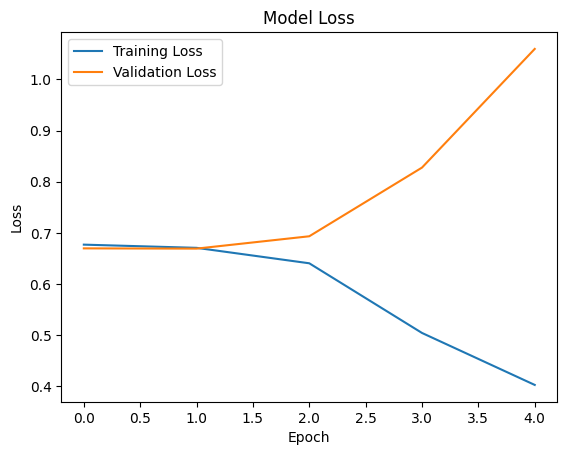

20/20 [==============================] - 2s 95ms/step - loss: 0.9877 - accuracy: 0.5308
Test Accuracy: 53.08%


In [141]:
model_CNN_vader(hot_vader_ret)

In [143]:
def model_CNN_LSTM(df, max_words=10000):
    df['text'] = df['text'].astype(str)

    # One-hot encoding for 'label' and 'ticker' columns
    one_hot_encoder = OneHotEncoder(sparse=False)
    label_one_hot = one_hot_encoder.fit_transform(df[['label']])
    ticker_one_hot = one_hot_encoder.fit_transform(df[['ticker']])
    df['score'] = df['score'].astype(float)

    # Separate features and target variable
    X_text = df['text']
    X_ticker = ticker_one_hot
    X_label = label_one_hot
    X_score = df['score'].values.reshape(-1, 1)
    y = (df['ret'] > 0).astype(int)

    # Split the data into training and testing sets
    X_train_text, X_test_text, X_train_ticker, X_test_ticker, X_train_label, X_test_label, X_train_score, X_test_score, y_train, y_test = train_test_split(X_text, X_ticker, X_label, X_score, y, test_size=0.2, random_state=42)

    # Tokenize and pad the 'text' column for training and testing sets
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train_text)
    train_text_sequences = tokenizer.texts_to_sequences(X_train_text)
    test_text_sequences = tokenizer.texts_to_sequences(X_test_text)
    max_sequence_length = max(len(s) for s in train_text_sequences + test_text_sequences)
    train_text_padded = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
    test_text_padded = pad_sequences(test_text_sequences, maxlen=max_sequence_length)

    # Text Input (CNN followed by LSTM)
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    text_embedding = Embedding(input_dim=max_words, output_dim=128)(text_input)
    text_conv1 = Conv1D(128, 3, activation='relu')(text_embedding)
    text_pool1 = MaxPooling1D(3)(text_conv1)
    text_conv2 = Conv1D(128, 3, activation='relu')(text_pool1)
    text_pool2 = MaxPooling1D(3)(text_conv2)
    text_lstm1 = LSTM(128, return_sequences=True)(text_pool2)
    text_lstm2 = LSTM(64)(text_lstm1)  # Additional LSTM layer
    text_dense = Dense(32, activation='relu')(text_lstm2)

    # Ticker Input (numeric)
    ticker_input_shape = X_ticker.shape[1]
    ticker_input = Input(shape=(ticker_input_shape,), name='ticker_input')
    ticker_dense = Dense(16, activation='relu')(ticker_input)

    # Label Input (numeric)
    label_input_shape = X_label.shape[1]
    label_input = Input(shape=(label_input_shape,), name='label_input')
    label_dense = Dense(16, activation='relu')(label_input)

    # Score Input (numeric)
    score_input = Input(shape=(1,), name='score_input')
    score_dense1 = Dense(16, activation='relu')(score_input)
    score_dense2 = Dense(8, activation='relu')(score_dense1)  # Additional dense layer

    # Concatenate all inputs
    concatenated = concatenate([text_dense, ticker_dense, label_dense, score_dense2])
    dense_1 = Dense(64, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(dense_1)

    # Build and compile the model
    model = Model(inputs=[text_input, ticker_input, label_input, score_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Model summary
    model.summary()

    # Train the model
    history = model.fit(
        {'text_input': train_text_padded, 'ticker_input': X_train_ticker, 'label_input': X_train_label, 'score_input': X_train_score},
        y_train,
        epochs=5,
        batch_size=32,
        validation_split=0.2
    )

    # Plot the loss
    plot_loss(history)

    # Evaluate the model
    loss, accuracy = model.evaluate(
        {'text_input': test_text_padded, 'ticker_input': X_test_ticker, 'label_input': X_test_label, 'score_input': X_test_score},
        y_test
    )
    print("Test Accuracy: {:.2f}%".format(accuracy * 100))


/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_23 (Embedding)    (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 conv1d_8 (Conv1D)           (None, 30, 128)              49280     ['embedding_23[0][0]']        
                                                                                                  
 max_pooling1d_8 (MaxPoolin  (None, 10, 128)              0         ['conv1d_8[0][0]']            
 g1D)                                                                                      

2023-08-15 22:30:45.070373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:30:47.324216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:30:48.690930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:30:53.295501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:30:55.325075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 0.6741 - accuracy: 0.6038

2023-08-15 22:31:27.434477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:31:28.376539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:31:29.263824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 52s 563ms/step - loss: 0.6741 - accuracy: 0.6038 - val_loss: 0.6681 - val_accuracy: 0.6126
Epoch 2/5
64/64 [==============================] - 21s 331ms/step - loss: 0.6700 - accuracy: 0.6057 - val_loss: 0.6686 - val_accuracy: 0.6126
Epoch 3/5
64/64 [==============================] - 25s 390ms/step - loss: 0.6587 - accuracy: 0.6161 - val_loss: 0.7235 - val_accuracy: 0.5672
Epoch 4/5
64/64 [==============================] - 10s 159ms/step - loss: 0.5102 - accuracy: 0.7204 - val_loss: 0.8944 - val_accuracy: 0.5435
Epoch 5/5
64/64 [==============================] - 10s 153ms/step - loss: 0.4142 - accuracy: 0.7811 - val_loss: 0.9543 - val_accuracy: 0.5632


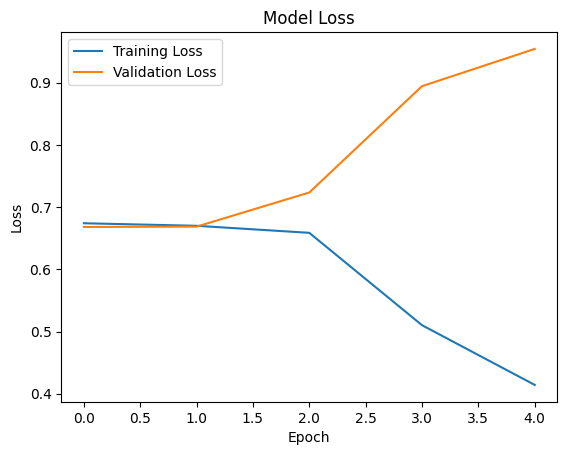

20/20 [==============================] - 3s 131ms/step - loss: 0.9271 - accuracy: 0.5450
Test Accuracy: 54.50%


In [144]:
model_CNN_LSTM(hot_finbert)

/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_24 (Embedding)    (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 conv1d_10 (Conv1D)          (None, 30, 128)              49280     ['embedding_24[0][0]']        
                                                                                                  
 max_pooling1d_10 (MaxPooli  (None, 10, 128)              0         ['conv1d_10[0][0]']           
 ng1D)                                                                                     

2023-08-15 22:35:16.617322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:35:19.340032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:35:20.312695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:35:25.406121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:35:28.343847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 0.6762 - accuracy: 0.5949

2023-08-15 22:36:05.218470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:36:06.576546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:36:07.564632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 75s 631ms/step - loss: 0.6762 - accuracy: 0.5949 - val_loss: 0.6669 - val_accuracy: 0.6107
Epoch 2/5
64/64 [==============================] - 13s 192ms/step - loss: 0.6719 - accuracy: 0.6047 - val_loss: 0.6685 - val_accuracy: 0.6107
Epoch 3/5
64/64 [==============================] - 9s 143ms/step - loss: 0.6499 - accuracy: 0.6265 - val_loss: 0.7642 - val_accuracy: 0.5711
Epoch 4/5
64/64 [==============================] - 7s 110ms/step - loss: 0.5021 - accuracy: 0.7401 - val_loss: 0.8428 - val_accuracy: 0.5810
Epoch 5/5
64/64 [==============================] - 9s 145ms/step - loss: 0.3901 - accuracy: 0.7930 - val_loss: 1.2631 - val_accuracy: 0.5573


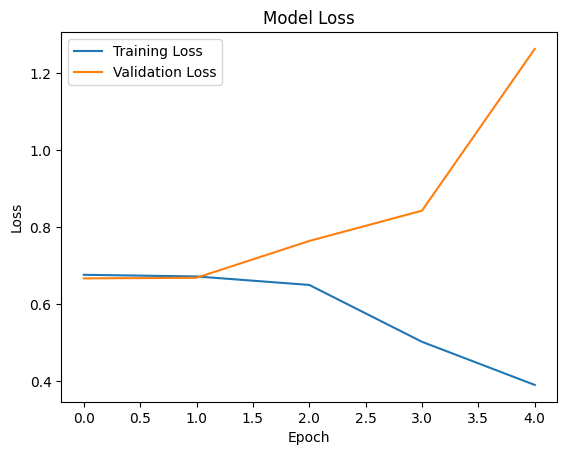

20/20 [==============================] - 6s 308ms/step - loss: 1.1031 - accuracy: 0.5450
Test Accuracy: 54.50%


In [145]:
model_CNN_LSTM(hot_chatgpt)

In [146]:
def model_CNN_LSTM_vader(df, max_words=10000):
    df['text'] = df['text'].astype(str)

    # One-hot encoding for 'ticker' column
    one_hot_encoder = OneHotEncoder(sparse=False)
    ticker_one_hot = one_hot_encoder.fit_transform(df[['ticker']])
    
    # Separate features and target variable
    X_text = df['text']
    X_ticker = ticker_one_hot
    X_neg = df['neg'].values.reshape(-1, 1)
    X_neu = df['neu'].values.reshape(-1, 1)
    X_pos = df['pos'].values.reshape(-1, 1)
    X_compound = df['compound'].values.reshape(-1, 1)
    y = (df['ret'] > 0).astype(int)

    # Split the data into training and testing sets
    X_train_text, X_test_text, X_train_ticker, X_test_ticker, X_train_neg, X_test_neg, X_train_neu, X_test_neu, X_train_pos, X_test_pos, X_train_compound, X_test_compound, y_train, y_test = train_test_split(X_text, X_ticker, X_neg, X_neu, X_pos, X_compound, y, test_size=0.2, random_state=42)

    # Tokenize and pad the 'text' column for training and testing sets
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train_text)
    train_text_sequences = tokenizer.texts_to_sequences(X_train_text)
    test_text_sequences = tokenizer.texts_to_sequences(X_test_text)
    max_sequence_length = max(len(s) for s in train_text_sequences + test_text_sequences)
    train_text_padded = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
    test_text_padded = pad_sequences(test_text_sequences, maxlen=max_sequence_length)

    # Text Input (CNN followed by LSTM)
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    text_embedding = Embedding(input_dim=max_words, output_dim=128)(text_input)
    text_conv1 = Conv1D(128, 3, activation='relu')(text_embedding)
    text_pool1 = MaxPooling1D(3)(text_conv1)
    text_conv2 = Conv1D(128, 3, activation='relu')(text_pool1)
    text_pool2 = MaxPooling1D(3)(text_conv2)
    text_lstm1 = LSTM(128, return_sequences=True)(text_pool2)
    text_lstm2 = LSTM(64)(text_lstm1)  # Additional LSTM layer
    text_dense = Dense(32, activation='relu')(text_lstm2)

    # Ticker Input (numeric)
    ticker_input_shape = X_ticker.shape[1]
    ticker_input = Input(shape=(ticker_input_shape,), name='ticker_input')
    ticker_dense = Dense(16, activation='relu')(ticker_input)

    # Sentiment Scores Input (numeric)
    neg_input = Input(shape=(1,), name='neg_input')
    neu_input = Input(shape=(1,), name='neu_input')
    pos_input = Input(shape=(1,), name='pos_input')
    compound_input = Input(shape=(1,), name='compound_input')

    # Concatenate sentiment scores
    sentiment_scores = concatenate([neg_input, neu_input, pos_input, compound_input])
    sentiment_dense = Dense(16, activation='relu')(sentiment_scores)

    # Concatenate all inputs
    concatenated = concatenate([text_dense, ticker_dense, sentiment_dense])
    dense_1 = Dense(64, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(dense_1)

    # Build and compile the model
    model = Model(inputs=[text_input, ticker_input, neg_input, neu_input, pos_input, compound_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Model summary
    model.summary()

    # Train the model
    history = model.fit(
        {'text_input': train_text_padded, 'ticker_input': X_train_ticker, 'neg_input': X_train_neg, 'neu_input': X_train_neu, 'pos_input': X_train_pos, 'compound_input': X_train_compound},
        y_train,
        epochs=5,
        batch_size=32,
        validation_split=0.2
    )

    # Plot the loss (you'll need to define or import a function to do this)
    plot_loss(history)

    # Evaluate the model
    loss, accuracy = model.evaluate(
        {'text_input': test_text_padded, 'ticker_input': X_test_ticker, 'neg_input': X_test_neg, 'neu_input': X_test_neu, 'pos_input': X_test_pos, 'compound_input': X_test_compound},
        y_test
    )
    print("Test Accuracy: {:.2f}%".format(accuracy * 100))


/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_25 (Embedding)    (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 conv1d_12 (Conv1D)          (None, 30, 128)              49280     ['embedding_25[0][0]']        
                                                                                                  
 max_pooling1d_12 (MaxPooli  (None, 10, 128)              0         ['conv1d_12[0][0]']           
 ng1D)                                                                                     

2023-08-15 22:52:07.321134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:52:15.129972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:52:16.519697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:52:21.302342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:52:23.342077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 0.6720 - accuracy: 0.6047

2023-08-15 22:52:56.935624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:52:57.998321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-15 22:52:58.809205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 62s 594ms/step - loss: 0.6720 - accuracy: 0.6047 - val_loss: 0.6669 - val_accuracy: 0.6126
Epoch 2/5
64/64 [==============================] - 11s 168ms/step - loss: 0.6694 - accuracy: 0.6057 - val_loss: 0.6681 - val_accuracy: 0.6126
Epoch 3/5
64/64 [==============================] - 9s 133ms/step - loss: 0.6543 - accuracy: 0.6201 - val_loss: 0.6908 - val_accuracy: 0.5692
Epoch 4/5
64/64 [==============================] - 7s 108ms/step - loss: 0.5038 - accuracy: 0.7416 - val_loss: 0.7811 - val_accuracy: 0.5791
Epoch 5/5
64/64 [==============================] - 7s 104ms/step - loss: 0.3944 - accuracy: 0.7969 - val_loss: 1.1334 - val_accuracy: 0.5632


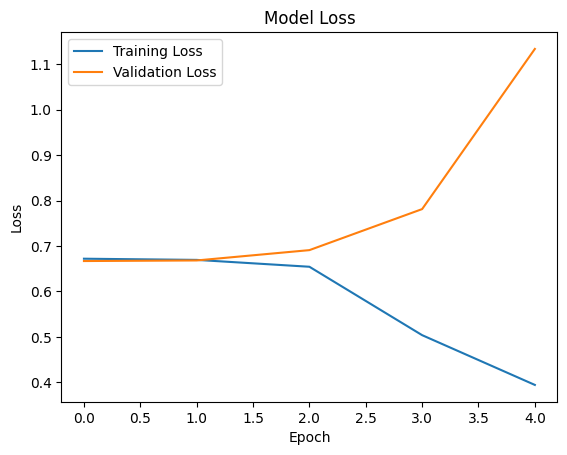

20/20 [==============================] - 3s 135ms/step - loss: 1.0264 - accuracy: 0.5608
Test Accuracy: 56.08%


In [147]:
model_CNN_LSTM_vader(hot_vader)